In [52]:
import yfinance as yf
import pandas as pd
from scr.config import START_DATE,END_DATE,STOCKS
import numpy as np

In [53]:

def download_close_prices(
	interval: str = "1d",
	auto_adjust: bool = True
):
	"""
	Downloads closing prices for a list of tickers in config file

	Parameters:
			interval : Daily, Weekly or Monthly data, e.g. '1d', '1wk', '1mo'
			auto_adjust : Adjust for splits/dividends
	Returns:
			all_data : A DataFrame of closing prices of each given stock
	"""
	tickers = STOCKS

	all_data = pd.DataFrame()
	
	for ticker in tickers:
		try:
			print(f"Downloading {ticker}...")
			data = yf.download(
				ticker,
				start=START_DATE,
				end=END_DATE,
				interval=interval,
				auto_adjust=auto_adjust,
				progress=False
			)
			if data.empty:
				print(f"No data returned for {ticker}")
				continue

			all_data[ticker] = data["Close"]

		except Exception as e:
			print(f"Failed to download {ticker}: {e}")
			continue

	if all_data.empty:
		raise ValueError("No valid ticker data downloaded.")

	return all_data

In [54]:



def clean_price_data(
	df: pd.DataFrame,
	drop_all_na: bool = True,
	forward_fill: bool = True,
	drop_remaining_na: bool = True
) -> pd.DataFrame:
	"""
	Cleans stock closing price data.

	Parameters:
			df : DataFrame with Date index and ticker columns
			drop_all_na : Drop rows where all tickers are NaN
			forward_fill : Forward fill missing values
			drop_remaining_na : Drop rows that still contain NaNs after filling

	Returns:
			df : Cleaned DataFrame
	"""
	# 1. Checking
	if not isinstance(df, pd.DataFrame):
		raise TypeError("Input must be a pandas DataFrame.")
	if df.empty:
		raise ValueError("Input DataFrame is empty.")
	try:
		df.index = pd.to_datetime(df.index)
	except Exception:
		raise ValueError("Index must be convertible to datetime.")

	# 2. Cleaning
	df = df.sort_index()
	df = df[~df.index.duplicated(keep="first")]


	if drop_all_na:
		df = df.dropna(how="all")
	if forward_fill:
		df = df.ffill()
	if drop_remaining_na:
		df = df.dropna()

	df = df.apply(pd.to_numeric, errors="coerce")

	if df.empty:
		raise ValueError("Feature engineering produced empty DataFrame.")
	
	return df

In [55]:
import numpy as np
import pandas as pd


def feature_engineering(
	price_df: pd.DataFrame,
	ticker: str,
	window: int = 5,
	num_lag_features: int = 3
) -> pd.DataFrame:
	"""
	Generate time-series features using log returns.
	No lookahead bias.
	"""

	# -------------------------
	# 1. Validation
	# -------------------------
	if not isinstance(price_df, pd.DataFrame):
		raise TypeError("price_df must be a pandas DataFrame.")

	if price_df.empty:
		raise ValueError("price_df is empty.")

	if ticker not in price_df.columns:
		raise ValueError(f"{ticker} not found in price_df.")

	if window <= 0:
		raise ValueError("window must be positive.")

	if num_lag_features <= 0:
		raise ValueError("num_lag_features must be positive.")

	# -------------------------
	# 2. Extract price series
	# -------------------------
	df = price_df[[ticker]].copy()
	df.columns = ["price"]

	if (df["price"] <= 0).any():
		raise ValueError("Prices must be strictly positive.")
		return
	# -------------------------
	# 3. Compute log returns
	# -------------------------
	df["log_return"] = np.log(df["price"]).diff()

	# -------------------------
	# 4. Lagged return features
	# -------------------------
	for i in range(1, num_lag_features + 1):
		df[f"lag_return_{i}"] = df["log_return"].shift(i)

	# -------------------------
	# 5. Rolling features (shifted to avoid leakage)
	# -------------------------
	# df["rolling_mean"] = (
	# 	df["log_return"]
	# 	.rolling(window)
	# 	.mean()
	# )

	# df["rolling_std"] = (
	# 	df["log_return"]
	# 	.rolling(window)
	# 	.std()
	# )

	# # Rate of change over window (momentum)
	# df["roc"] = (
	# 	df["price"]
	# 	.pct_change(window)
	# )

	# -------------------------
	# 6. Target (next return)
	# -------------------------
	df["target"] = df["log_return"]

	df = df.dropna()

	if df.empty:
		raise ValueError("Feature engineering resulted in empty DataFrame.")

	return df

In [56]:



# def feature_engineering(
# 		price_df: pd.DataFrame,
# 		ticker: str,
# 		window: int = 5,
# 		num_lag_features: int = 3

# )-> pd.DataFrame:
# 	"""
# 	Generate time-series features (lagged and rolling) from closing price data for a single stock.

# 	Parameters:
# 		price_df : DataFrame containing closing prices of multiple stocks.
# 					- Index must be datetime-like.
# 					- Columns must contain ticker symbols.
# 					- Each column represents the closing prices of one stock.
# 		ticker : The ticker symbol corresponding to the column in `price_df` for which features are to be generated.
# 		window : Lookback window size for rolling statistics.
# 		num_lag_features : Number of lagged price features to create.

# 	Returns:
# 		pd.DataFrame: DataFrame indexed by date containing:
# 					- price : Original closing price
# 					- lag_i : Lagged prices (i = 1,...,num_lag_features)
# 					- Rolling_Mean : Rolling mean of price over `window`
# 					- Rolling_Std  : Rolling standard deviation over `window`
# 					- ROC : Rate of Change over `window` periods
# 	"""

# 	# 1. Checking
# 	if not isinstance(price_df, pd.DataFrame):
# 		raise TypeError("price_df must be a pandas DataFrame.")
# 	if not isinstance(window, int) or window <= 0:
# 		raise ValueError("window must be a positive integer.")
# 	if not isinstance(num_lag_features, int) or num_lag_features <= 0:
# 		raise ValueError("num_lag_features must be a positive integer.")
	
# 	if price_df.empty:
# 		raise ValueError("price_df is empty.")
# 	if ticker not in price_df.columns:
# 		raise ValueError(f"{ticker} not found in price_df.")
	
# 	# 2. Obtaining the closing prices of the stock
# 	df = price_df[[ticker]].copy()
# 	df.columns = ["prices"]


# 	# 3. Lag features
# 	for i in range(1,num_lag_features+1):
# 		feature = f'lag_{i}'
# 		df[feature] = df['prices'].shift(i)

# 	# # 4. Rolling window features
# 	# df['Rolling_Mean'] = df['prices'].rolling(window).mean()
# 	# df['Rolling_Std'] = df['prices'].rolling(window).std()
# 	# # df['ROC'] = df['prices'].pct_change(periods=window)

# 	df = df.dropna()

# 	if df.empty:
# 		raise ValueError("Feature engineering produced empty DataFrame.")
	

# 	return df




In [57]:
from typing import Tuple
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def train(
	X_train: pd.DataFrame,
	y_train: pd.Series,
	given_model: BaseEstimator
) -> BaseEstimator:
	"""
	Trains a given sklearn model on provided training data.

	Parameters:
			X_train: features dataset with training data (n,num_features)
			y_train: prediction dataset with testing dats (n,)
			given_model: The ML model we are working with
	"""
	if X_train.empty:
		raise ValueError("X_train is empty.")
	if y_train.empty:
		raise ValueError("y_train is empty.")
	if len(X_train) != len(y_train):
		raise ValueError("X_train and y_train must have the same length.")
	if not hasattr(given_model, "fit"):
		raise TypeError("given_model must implement a .fit() method.")

	model = given_model
	model.fit(X_train, y_train)

	return model


def get_predictions(
	price_df: pd.DataFrame,
	ticker: str,
	given_model: BaseEstimator,
	test_size: float = 0.2,
	random_state: int = 42,
) -> Tuple[BaseEstimator, pd.DataFrame, pd.Series]:
	"""
	Performs feature engineering, splits data, trains model,
	and returns the latest prediction.
	"""
	print(f"Starting prediction for {ticker}....")
	if not isinstance(price_df, pd.DataFrame):
		raise TypeError("price_df must be a pandas DataFrame.")
	if price_df.empty:
		raise ValueError("price_df is empty.")
	if not isinstance(ticker, str):
		raise TypeError("ticker must be a string.")

	new_df = feature_engineering(price_df, ticker)

	

	if 'target' not in new_df.columns:
		raise KeyError("'target' column not found after feature engineering.")
	
	feature_cols = new_df.columns.drop(['target'])
	new_df[feature_cols] = new_df[feature_cols].shift(1)
	new_df = new_df.dropna()

	X = new_df[feature_cols]
	y = new_df['target']

	if X.empty:
		raise ValueError("Feature matrix X is empty after processing.")

	X_train, X_test, y_train, y_test = train_test_split(X,y,
		test_size=test_size,
		random_state=random_state,
		shuffle=True
	)

	model = train(
		X_train,
		y_train,
		given_model = given_model
	)

	print(f"Model trained for {ticker}")
	y_pred = model.predict(X_test)

	accuracy = mean_squared_error(list(y_test),list(y_pred))
	print(f"The model has an accuracy of {accuracy}")
	latest_pred = y_pred[-1]

	plt.plot(list(y_test),label="true")
	plt.plot(list(y_pred),label="pred")
	plt.show()
	return latest_pred


In [58]:

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

df = download_close_prices()

df = clean_price_data(df)

tickers = df.columns




Starting prediction for AAPL....
Model trained for AAPL
The model has an accuracy of 0.0005311638727586164


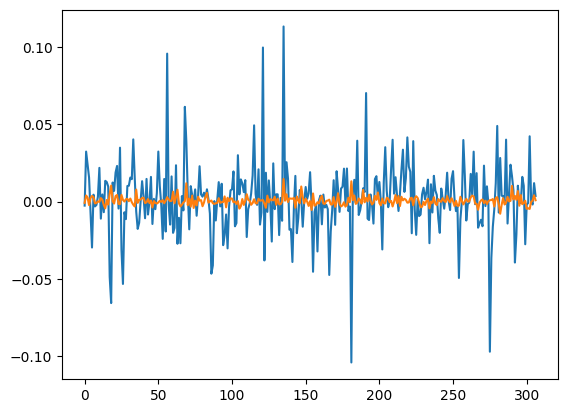

Starting prediction for MSFT....
Model trained for MSFT
The model has an accuracy of 0.00041193943318956706


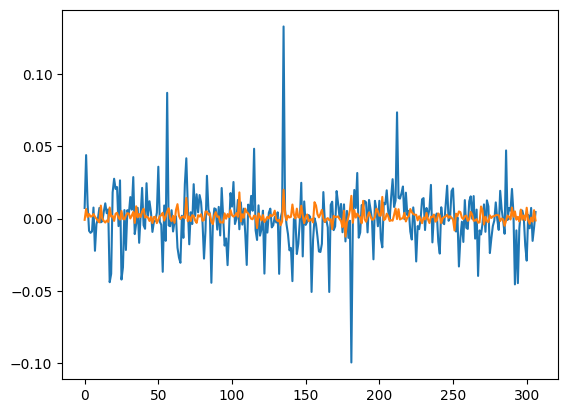

Starting prediction for TSLA....
Model trained for TSLA
The model has an accuracy of 0.00152105992772404


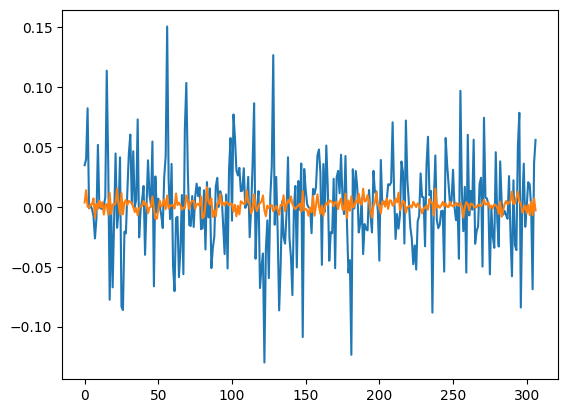

Starting prediction for GOOG....
Model trained for GOOG
The model has an accuracy of 0.0004154616465785227


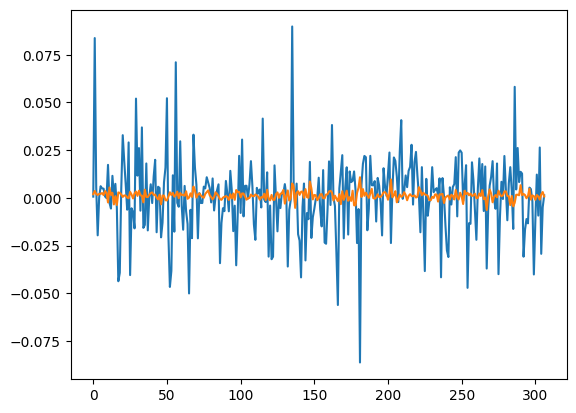

[np.float64(0.0008595836760597348), np.float64(-0.0013231680771459892), np.float64(-0.002920168900823113), np.float64(0.0007124769898169552)]


In [59]:

predictions = []


for ticker in tickers:
    latest_pred = get_predictions(df,ticker,LinearRegression())
    predictions.append(latest_pred)

print(predictions)

In [60]:
predictions

[np.float64(0.0008595836760597348),
 np.float64(-0.0013231680771459892),
 np.float64(-0.002920168900823113),
 np.float64(0.0007124769898169552)]

In [19]:
import yfinance as yf
import pandas as pd
from scr.config import START_DATE,END_DATE,STOCKS

df =  yf.download("AAPL", start=START_DATE, progress=False)
df.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.400536,72.460799,71.156697,71.409800,135480400
2020-01-03,71.696640,72.455958,71.472462,71.629145,146322800
2020-01-06,72.267937,72.306506,70.568510,70.819208,118387200
2020-01-07,71.928047,72.533087,71.708687,72.277571,108872000
2020-01-08,73.085121,73.386438,71.631567,71.631567,132079200


In [20]:
df = df.reset_index()
df.head()

Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
0,2020-01-02,72.400536,72.460799,71.156697,71.409800,135480400
1,2020-01-03,71.696640,72.455958,71.472462,71.629145,146322800
2,2020-01-06,72.267937,72.306506,70.568510,70.819208,118387200
3,2020-01-07,71.928047,72.533087,71.708687,72.277571,108872000
4,2020-01-08,73.085121,73.386438,71.631567,71.631567,132079200


In [21]:
df.columns = df.columns.droplevel(1)
df.columns = ['Date','Close','High','Low','Open','Volume']
df.columns = df.columns.str.lower()
df.head()

,date,close,high,low,open,volume
0,2020-01-02,72.400536,72.460799,71.156697,71.409800,135480400
1,2020-01-03,71.696640,72.455958,71.472462,71.629145,146322800
2,2020-01-06,72.267937,72.306506,70.568510,70.819208,118387200
3,2020-01-07,71.928047,72.533087,71.708687,72.277571,108872000
4,2020-01-08,73.085121,73.386438,71.631567,71.631567,132079200


In [22]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()

,close,high,low,open,volume
date,,,,,
2020-01-02,72.400536,72.460799,71.156697,71.409800,135480400
2020-01-03,71.696640,72.455958,71.472462,71.629145,146322800
2020-01-06,72.267937,72.306506,70.568510,70.819208,118387200
2020-01-07,71.928047,72.533087,71.708687,72.277571,108872000
2020-01-08,73.085121,73.386438,71.631567,71.631567,132079200


In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scr.logger import setup_logger

logger = setup_logger()

RETURNS_PATH = "data/processed/returns.parquet"


def load_returns():
    returns = pd.read_parquet(RETURNS_PATH)
    logger.info("Returns loaded for portfolio engine")
    return returns

def estimate_statistics(returns:pd.DataFrame) -> tuple[int,int]:
    """
    Estimate annualized expected return and covariance
    """
    mu = returns.mean() * 252
    cov = returns.cov() * 252
    return mu, cov

df = load_returns()
df

,AAPL,MSFT,TSLA,GOOG
Date,,,,
2020-01-03,-0.009722,-0.012452,0.029633,-0.004907
2020-01-06,0.007968,0.002585,0.019255,0.024657
2020-01-07,-0.004703,-0.009118,0.038801,-0.000624
2020-01-08,0.016086,0.015928,0.049205,0.007880
2020-01-09,0.021241,0.012493,-0.021945,0.011044
...,...,...,...,...
2026-02-10,-0.003423,-0.000798,0.018906,-0.017787
2026-02-11,0.006650,-0.021536,0.007196,-0.022911
2026-02-12,-0.049982,-0.006257,-0.026152,-0.006296


In [2]:
mu,cov = estimate_statistics(df)
type(mu)

pandas.core.series.Series

In [3]:
cov

,AAPL,MSFT,TSLA,GOOG
AAPL,0.100759,0.065225,0.101751,0.063013
MSFT,0.065225,0.088859,0.087561,0.065319
TSLA,0.101751,0.087561,0.437142,0.089302
GOOG,0.063013,0.065319,0.089302,0.103175


In [4]:
def portfolio_performance(weights, mu, cov):
    """
    Returns (return, volatility, sharpe)
    """
    ret = np.dot(weights, mu)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    sharpe = ret / vol

    return ret, vol, sharpe

In [5]:
def optimize_portfolio(mu, cov):

    n = len(mu)

    def neg_sharpe(weights):
        ret, vol, sharpe = portfolio_performance(weights, mu, cov)
        return -sharpe

    constraints = ({
        'type': 'eq',
        'fun': lambda w: np.sum(w) - 1
    })

    bounds = tuple((0,1) for _ in range(n))
    init_guess = np.ones(n) / n

    result = minimize(
        neg_sharpe,
        init_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    # logger.info("Portfolio optimization complete")
    return result.x

ans = optimize_portfolio(mu, cov)
ans



array([0.1601425 , 0.        , 0.32228174, 0.51757576])

In [ ]:
def portfolio_metrics(weights, returns):

    port_returns = returns @ weights

    ann_return = port_returns.mean() * 252
    ann_vol = port_returns.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol

    # If I started with ₹1, how much money would I have each day?
    cumulative = (1 + port_returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    max_dd = drawdown.min()

    return {
        "Annual Return": ann_return,
        "Annual Volatility": ann_vol,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": max_dd
    }

print(portfolio_metrics(ans,df))

{'Annual Return': np.float64(0.40631567424454684), 'Annual Volatility': np.float64(0.35548255175224003), 'Sharpe Ratio': np.float64(1.1429975177170886), 'Max Drawdown': np.float64(-0.5051920848880881)}


In [10]:
def monte_carlo_simulation(weights, mu, cov, days=252, sims=3000):

    port_mu = np.dot(weights, mu)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))

    results = []

    for _ in range(sims):
        simulated_returns = np.random.normal(
            port_mu/252,
            port_vol/np.sqrt(252),
            days
        )

        path = (1 + simulated_returns).cumprod()
        results.append(path[-1])

    return np.array(results)

results = monte_carlo_simulation(ans, mu, cov)
results

array([1.54694451, 1.03676311, 1.48075205, ..., 2.25183163, 2.09346597,
       1.44013882], shape=(3000,))

In [13]:
def monte_carlo_risk(simulated_values):

    var_95 = np.percentile(simulated_values, 5)
    cvar_95 = simulated_values[simulated_values <= var_95].mean()

    return {
        "VaR 95%": var_95,
        "CVaR 95%": cvar_95
    }
print(monte_carlo_risk(results))

{'VaR 95%': np.float64(0.7746004802924399), 'CVaR 95%': np.float64(0.6788734848705035)}


In [25]:
def compute_var_cvar(simulated_values, confidence=0.95):

    percentile = 100 * (1 - confidence)

    var = np.percentile(simulated_values, percentile)

    cvar = simulated_values[simulated_values <= var].mean()

    return var, cvar


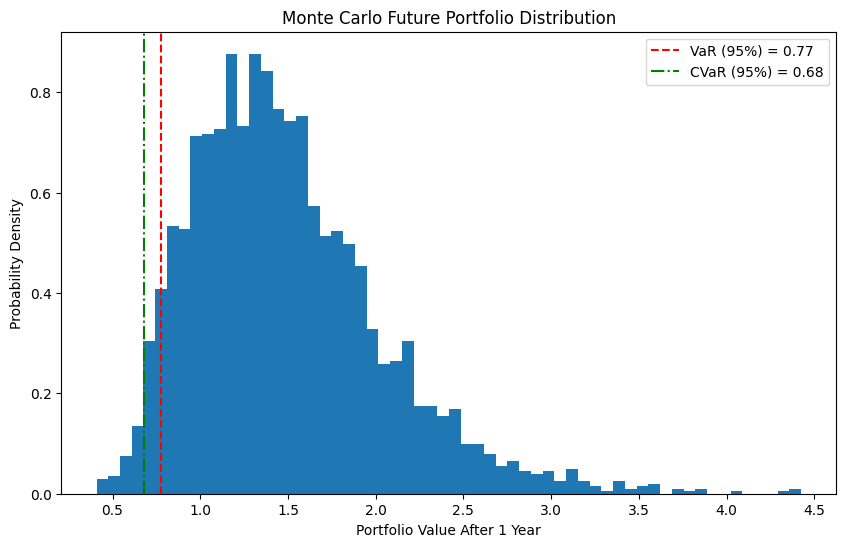

In [26]:
plt.figure(figsize=(10,6))

plt.hist(results, bins=60, density=True)

plt.xlabel("Portfolio Value After 1 Year")
plt.ylabel("Probability Density")
plt.title("Monte Carlo Future Portfolio Distribution")

var, cvar = compute_var_cvar(results)

plt.axvline(var, linestyle="--", label=f"VaR (95%) = {var:.2f}",color="red")
plt.axvline(cvar, linestyle="-.", label=f"CVaR (95%) = {cvar:.2f}",color="green")

plt.xlabel("Portfolio Value After 1 Year")
plt.ylabel("Probability Density")
plt.title("Monte Carlo Future Portfolio Distribution")

plt.legend()
plt.show()

In [ ]:
"VaR tells you the loss level that you will not exceed most of the time."

In [7]:
port_returns = df @ ans
equity_curve = (1 + port_returns).cumprod()

<Axes: xlabel='Date'>

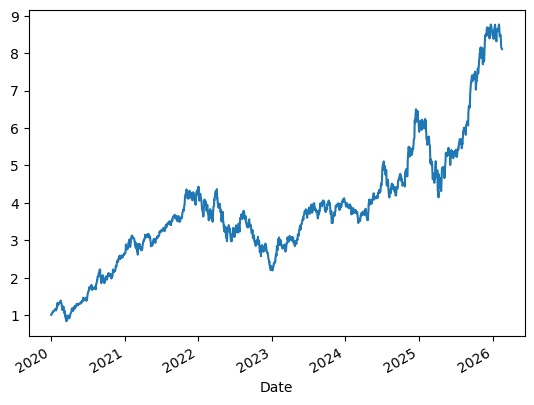

In [8]:

equity_curve.plot()

array([[<Axes: title={'center': 'AAPL'}>,
        <Axes: title={'center': 'MSFT'}>],
       [<Axes: title={'center': 'TSLA'}>,
        <Axes: title={'center': 'GOOG'}>]], dtype=object)

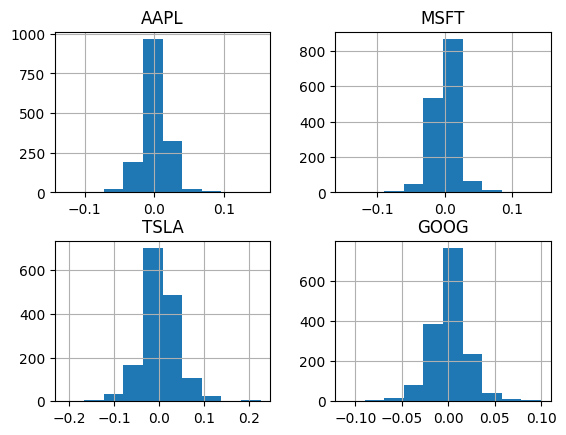

In [9]:
df.hist()

In [2]:
from scr.portfolio_making import load_returns

returns = load_returns()
returns

,AAPL,MSFT,TSLA,GOOG
Date,,,,
2020-01-03,-0.009722,-0.012452,0.029633,-0.004907
2020-01-06,0.007968,0.002585,0.019255,0.024657
2020-01-07,-0.004703,-0.009118,0.038801,-0.000624
2020-01-08,0.016086,0.015928,0.049205,0.007880
2020-01-09,0.021241,0.012493,-0.021945,0.011044
...,...,...,...,...
2026-02-12,-0.049982,-0.006257,-0.026152,-0.006296
2026-02-13,-0.022733,-0.001294,0.000887,-0.010828
2026-02-17,0.031668,-0.011113,-0.016314,-0.010457


In [5]:
import yfinance as yf
from scr.config import START_DATE,END_DATE,STOCKS
data = yf.download("AAPL", start=START_DATE, end=END_DATE, auto_adjust=True)
data

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.400528,72.460791,71.156689,71.409793,135480400
2020-01-03,71.696617,72.455935,71.472439,71.629122,146322800
2020-01-06,72.267914,72.306483,70.568488,70.819186,118387200
2020-01-07,71.928047,72.533087,71.708687,72.277571,108872000
2020-01-08,73.085106,73.386423,71.631552,71.631552,132079200
...,...,...,...,...,...
2026-02-11,275.500000,280.179993,274.450012,274.700012,51931300
2026-02-12,261.730011,275.720001,260.179993,275.589996,81077200


In [6]:
retrns = data['Close']
retrns

Ticker,AAPL
Date,
2020-01-02,72.400528
2020-01-03,71.696617
2020-01-06,72.267914
2020-01-07,71.928047
2020-01-08,73.085106
...,...
2026-02-11,275.500000
2026-02-12,261.730011
2026-02-13,255.779999


In [8]:
ans = retrns.pct_change().dropna()
ans

Ticker,AAPL
Date,
2020-01-03,-0.009722
2020-01-06,0.007968
2020-01-07,-0.004703
2020-01-08,0.016086
2020-01-09,0.021241
...,...
2026-02-11,0.006650
2026-02-12,-0.049982
2026-02-13,-0.022733


In [9]:
returns

,AAPL,MSFT,TSLA,GOOG
Date,,,,
2020-01-03,-0.009722,-0.012452,0.029633,-0.004907
2020-01-06,0.007968,0.002585,0.019255,0.024657
2020-01-07,-0.004703,-0.009118,0.038801,-0.000624
2020-01-08,0.016086,0.015928,0.049205,0.007880
2020-01-09,0.021241,0.012493,-0.021945,0.011044
...,...,...,...,...
2026-02-12,-0.049982,-0.006257,-0.026152,-0.006296
2026-02-13,-0.022733,-0.001294,0.000887,-0.010828
2026-02-17,0.031668,-0.011113,-0.016314,-0.010457


In [10]:
print(returns.columns)

Index(['AAPL', 'MSFT', 'TSLA', 'GOOG'], dtype='object')


<Axes: xlabel='Date'>

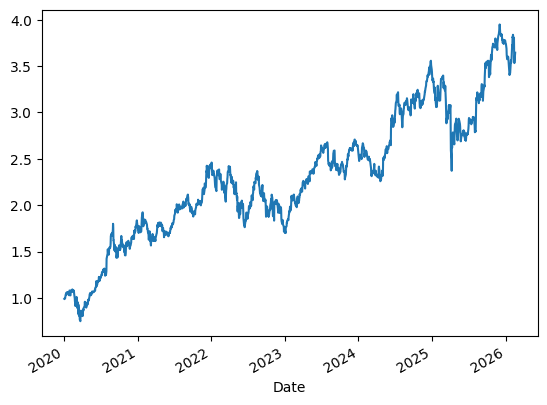

In [30]:
based = returns['AAPL']
based = (1 + based).cumprod()
based.plot()

In [1]:
from scr.portfolio_making import optimized_portfolio_construction

portfolio_optimal = optimized_portfolio_construction()

portfolio_optimal

PortfolioResults(weights=array([1.60712709e-01, 7.99344992e-17, 3.22456403e-01, 5.16830888e-01]), metrics={'Annual Return': np.float64(0.40618328877117593), 'Annual Volatility': np.float64(0.3552903274127265), 'Sharpe Ratio': np.float64(1.143243306760021), 'Max Drawdown': np.float64(-0.5052132908388852)}, var=np.float64(0.7959707089730839), cvar=np.float64(0.6871212649559078))

In [1]:
from scipy.optimize import minimize

def random_portfolio_metrics(mu, cov, rf = 0.05, n_portfolios=5000):
	n_assets = len(mu)
	weights_list = np.random.dirichlet(np.ones(n_assets), size=n_portfolios)

	rets = []
	vols = []
	sharpes = []

	for w in weights_list:
		r, v, _ = portfolio_performance(w,mu, cov,0.05)
		rets.append(r)
		vols.append(v)
		sharpes.append((r - rf) / v)

	rets = np.array(rets)
	vols = np.array(vols)
	sharpes = np.array(sharpes)

	return rets, vols, sharpes

def frontier_volatalities(mu,cov):
	n_assets = len(mu)
	target_returns = np.linspace(mu.min(), mu.max(), 60)
	frontier_vols = []

	bounds = tuple((0,1) for _ in range(n_assets))
	init = np.ones(n_assets)/n_assets

	for target in target_returns:

		constraints = (
			{'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
			{'type': 'eq', 'fun': lambda w: w @ mu - target}
		)

		result = minimize(
			lambda w: w @ cov @ w,
			init,
			method='SLSQP',
			bounds=bounds,
			constraints=constraints
		)

		frontier_vols.append(np.sqrt(result.fun))

	frontier_vols = np.array(frontier_vols)
	return frontier_vols,target_returns

def compute_frontier_data(mu, cov):
    rets, vols, sharpes = random_portfolio_metrics(mu, cov)
    frontier_vols, target_returns = frontier_volatalities(mu, cov)

    return {
        "cloud_vols": vols,
        "cloud_rets": rets,
        "cloud_sharpes": sharpes,
        "frontier_vols": frontier_vols,
        "frontier_rets": target_returns
    }
    

In [2]:
import plotly.graph_objects as go

def plot_efficient_frontier(portfolios,frontier_data):
	fig = go.Figure()

	vols = frontier_data["cloud_vols"]
	rets = frontier_data["cloud_rets"]
	sharpes = frontier_data["cloud_sharpes"]
	frontier_vols = frontier_data["frontier_vols"]
	target_returns = frontier_data["frontier_rets"]


	# rets, vols, sharpes = random_portfolio_metrics(mu,cov)
	# frontier_vols,target_returns = frontier_volatalities(mu,cov)

	# Random portfolios cloud
	fig.add_trace(go.Scatter(
		x=vols,
		y=rets,
		mode='markers',
		marker=dict(
			size=2,
			color=sharpes,
			colorscale='Viridis',
			showscale=True,
			colorbar=dict(title="Sharpe Ratio"),
			opacity=0.5
		),
		name="Random Portfolios",
		showlegend=False,
		hoverinfo='skip'
	))

	# Efficient frontier curve
	fig.add_trace(go.Scatter(
		x=frontier_vols,
		y=target_returns,
		mode='lines',
		line=dict(color='black', width=4),
		name="Efficient Frontier",
		hovertemplate=
			"Volatility: %{x:.2%}<br>" +
			"Return: %{y:.2%}<extra></extra>"
	))
		
	for p in portfolios:
		vol = p.metrics.annual_volatility
		ret = p.metrics.annual_return
		sharpe = p.metrics.sharpe_ratio

		if p.name == "Optimal":
			marker = dict(size=18,color='red',symbol='star')
		else:
			marker = dict(size=16)

		fig.add_trace(go.Scatter(
			x=[vol],
			y=[ret],
			customdata=[[sharpe]],
			mode="markers",
			marker=marker,
			name=p.name,
			hovertemplate=
				"<b>%{fullData.name}</b><br>" +
				"Sharpe: %{customdata[0]:.2f}<br>" +
				"Volatility: %{x:.2%}<br>" +
				"Return: %{y:.2%}<extra></extra>"
		))
		
	fig.update_layout(
		title="Markowitz Efficient Frontier",
		xaxis_title="Annualized Volatility (Risk)",
		yaxis_title="Annualized Expected Return",
		template="plotly_white",
		width=950,
		height=650 ,
		# xaxis=dict(range=[0.25, 0.5]),
		legend=dict(
		x=0.02,
		y=0.98,
		bgcolor="rgba(0,0,0,0)",
		borderwidth=0,
		itemsizing="constant"
	)
	)

	fig.show(renderer="browser")


In [6]:
from scr.portfolio_making import load_returns,estimate_statistics,portfolio_performance,optimized_portfolio_construction, general_portfolio_construction
import numpy as np

tickers = ["AAPL","MSFT"]
returns = load_returns()
returns = returns[tickers]
mu, cov = estimate_statistics(returns)


opt_portfolio = optimized_portfolio_construction(tickers)


my_weights = np.array([0.5, 0.5])  # example

my_portfolio = general_portfolio_construction(tickers,my_weights,"my_portfolio")

portfolios = [opt_portfolio,my_portfolio]

frontier_data = compute_frontier_data(mu, cov)
plot_efficient_frontier(portfolios, frontier_data)

In [2]:
opt_portfolio

PortfolioResults(name='Optimal', weights=array([0.7527245, 0.2472755]), metrics=PortfolioMetrics(annual_return=np.float64(0.24736606579967532), annual_volatility=np.float64(0.29443431505336604), sharpe_ratio=np.float64(0.8401400691180998), max_drawdown=np.float64(-0.31116764593954577)), var=np.float64(0.7567141881342149), cvar=np.float64(0.6815029251317154))

In [ ]:
opt_portfolio = optimized_portfolio_construction()

In [5]:
opt_portfolio.name

'Optimal'

In [6]:
my_portfolio.name

'my_portfolio'

In [5]:
opt_portfolio

NameError: name 'opt_portfolio' is not defined

In [12]:
import plotly.graph_objects as go
import numpy as np

# -----------------------------
# Create Plotly Figure
# -----------------------------
fig = go.Figure()

# Random portfolios cloud
fig.add_trace(go.Scatter(
    x=vols,
    y=rets,
    mode='markers',
    marker=dict(
        size=2,
        color=sharpes,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title="Sharpe Ratio"),
        opacity=0.5
    ),
    name="Random Portfolios",
    showlegend=False,
    hoverinfo='skip'
))

# Efficient frontier curve
fig.add_trace(go.Scatter(
    x=frontier_vols,
    y=target_returns,
    mode='lines',
    line=dict(color='black', width=4),
    name="Efficient Frontier",
    hovertemplate=
        "Volatility: %{x:.2%}<br>" +
        "Return: %{y:.2%}<extra></extra>"
))

# Max Sharpe portfolio
fig.add_trace(go.Scatter(
    x=[opt_vol],
    y=[opt_ret],
    customdata=[[opt_sharpe]],
    mode='markers',
    marker=dict(
        size=18,
        color='red',
        symbol='star'
    ),
    name="Max Sharpe Portfolio",
    hovertemplate=
		"Sharpe: %{customdata[0]:.2f}<br>" +
        "Volatility: %{x:.2%}<br>" +
        "Return: %{y:.2%}<extra></extra>"
))

# Your portfolio
fig.add_trace(go.Scatter(
    x=[my_vol],
    y=[my_ret],
    customdata=[[my_sharpe]],
    mode='markers',
    marker=dict(
        size=18,
        color='blue',
        symbol='cross'
    ),
    name="My Portfolio",
    hovertemplate=
        "Sharpe: %{customdata[0]:.2f}<br>" +
        "Volatility: %{x:.2%}<br>" +
        "Return: %{y:.2%}<extra></extra>"
))

# -----------------------------
# Layout Styling
# -----------------------------
fig.update_layout(
    title="Markowitz Efficient Frontier",
    xaxis_title="Annualized Volatility (Risk)",
    yaxis_title="Annualized Expected Return",
    template="plotly_white",
    width=950,
    height=650 ,
    # xaxis=dict(range=[0.25, 0.5]),
	legend=dict(
    x=0.02,
    y=0.98,
    bgcolor="rgba(0,0,0,0)",
    borderwidth=0,
    itemsizing="constant"
)
)
fig.show(renderer="browser")


In [ ]:
my_weights = np.array([0.25, 0.25, 0.25, 0.25])  # example


def portfolio_stats(weights, mu, cov):
    ret = weights @ mu
    vol = np.sqrt(weights @ cov @ weights)
    return ret, vol

my_ret, my_vol = portfolio_stats(my_weights, mu, cov)
# -----------------------------
# 6) Plot
# -----------------------------
plt.figure(figsize=(11,8))

# Random portfolios cloud
plt.scatter(vols, rets, c=sharpes, cmap='viridis', alpha=0.4)
plt.colorbar(label='Sharpe Ratio')

plt.scatter(my_vol, my_ret,
            color='blue',
            marker='x',
            s=200,
            label='My Portfolio')

# Efficient frontier curve
plt.plot(frontier_vols, target_returns, color='black', linewidth=1, label='Efficient Frontier')

# Max Sharpe portfolio
plt.scatter(opt_vol, opt_ret, color='red', marker='o', s=350, label='Max Sharpe Portfolio')

plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.title("Markowitz Efficient Frontier")
plt.legend()
plt.show()


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# -----------------------------
# 1) Estimate statistics
# -----------------------------
# returns: DataFrame of DAILY SIMPLE RETURNS (rows=dates, cols=assets)

mu = returns.mean() * 252          # annualized returns
cov = returns.cov() * 252          # annualized covariance
n_assets = len(mu)
rf = 0.05                          # risk-free rate (5%)

# -----------------------------
# 2) Portfolio stats function
# -----------------------------
def portfolio_stats(weights, mu, cov):
    ret = weights @ mu
    vol = np.sqrt(weights @ cov @ weights)
    return ret, vol

# -----------------------------
# 3) Generate random portfolios
# -----------------------------
n_portfolios = 5000
weights_list = np.random.dirichlet(np.ones(n_assets), size=n_portfolios)

rets = []
vols = []
sharpes = []

for w in weights_list:
    r, v = portfolio_stats(w, mu, cov)
    rets.append(r)
    vols.append(v)
    sharpes.append((r - rf) / v)

rets = np.array(rets)
vols = np.array(vols)
sharpes = np.array(sharpes)

# -----------------------------
# 4) Max Sharpe Portfolio
# -----------------------------
def neg_sharpe(weights):
    r, v = portfolio_stats(weights, mu, cov)
    return -(r - rf) / v

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = tuple((0,1) for _ in range(n_assets))
init = np.ones(n_assets)/n_assets

opt = minimize(neg_sharpe, init, method='SLSQP', bounds=bounds, constraints=constraints)
opt_w = opt.x
opt_ret, opt_vol = portfolio_stats(opt_w, mu, cov)
opt_ret, opt_vol

(np.float64(0.4394126462420824), np.float64(0.3863834708064773))

In [4]:
opt.x

array([7.17307386e-02, 7.28583860e-17, 4.06907706e-01, 5.21361555e-01])

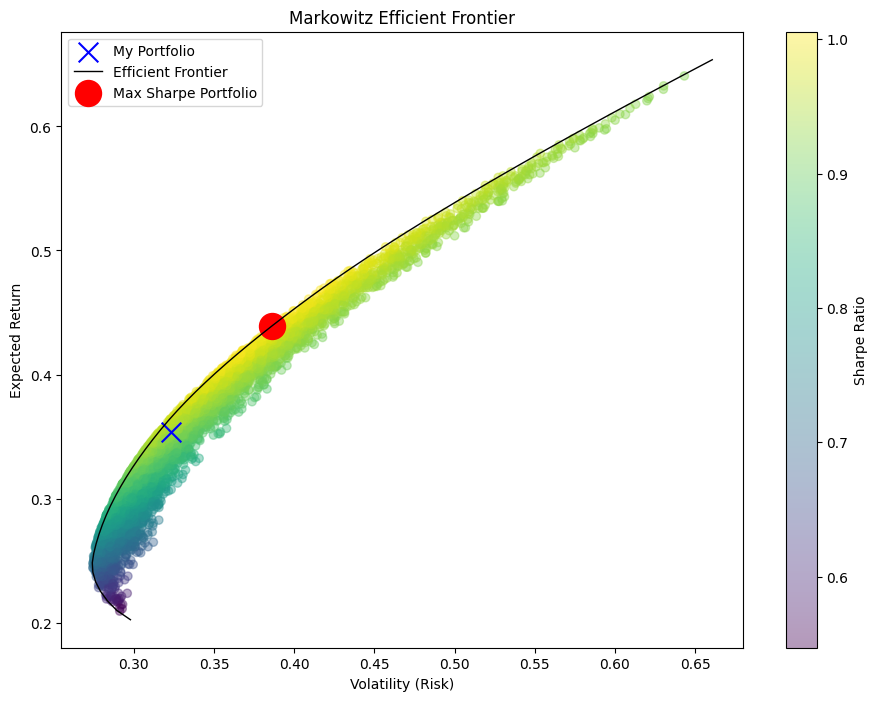

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# -----------------------------
# 1) Estimate statistics
# -----------------------------
# returns: DataFrame of DAILY SIMPLE RETURNS (rows=dates, cols=assets)

mu = returns.mean() * 252          # annualized returns
cov = returns.cov() * 252          # annualized covariance
n_assets = len(mu)
rf = 0.05                          # risk-free rate (5%)

# -----------------------------
# 2) Portfolio stats function
# -----------------------------
def portfolio_stats(weights, mu, cov):
    ret = weights @ mu
    vol = np.sqrt(weights @ cov @ weights)
    return ret, vol

# -----------------------------
# 3) Generate random portfolios
# -----------------------------
n_portfolios = 5000
weights_list = np.random.dirichlet(np.ones(n_assets), size=n_portfolios)

rets = []
vols = []
sharpes = []

for w in weights_list:
    r, v = portfolio_stats(w, mu, cov)
    rets.append(r)
    vols.append(v)
    sharpes.append((r - rf) / v)

rets = np.array(rets)
vols = np.array(vols)
sharpes = np.array(sharpes)

# -----------------------------
# 4) Max Sharpe Portfolio
# -----------------------------
def neg_sharpe(weights):
    r, v = portfolio_stats(weights, mu, cov)
    return -(r - rf) / v

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = tuple((0,1) for _ in range(n_assets))
init = np.ones(n_assets)/n_assets

opt = minimize(neg_sharpe, init, method='SLSQP', bounds=bounds, constraints=constraints)
opt_w = opt.x
opt_ret, opt_vol = portfolio_stats(opt_w, mu, cov)

# -----------------------------
# 5) Efficient Frontier
# -----------------------------
target_returns = np.linspace(mu.min(), mu.max(), 60)
frontier_vols = []

for target in target_returns:

    constraints = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: w @ mu - target}
    )

    result = minimize(
        lambda w: w @ cov @ w,
        init,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    frontier_vols.append(np.sqrt(result.fun))

frontier_vols = np.array(frontier_vols)

my_weights = np.array([0.25, 0.25, 0.25, 0.25])  # example


def portfolio_stats(weights, mu, cov):
    ret = weights @ mu
    vol = np.sqrt(weights @ cov @ weights)
    return ret, vol

my_ret, my_vol = portfolio_stats(my_weights, mu, cov)
# -----------------------------
# 6) Plot
# -----------------------------
plt.figure(figsize=(11,8))

# Random portfolios cloud
plt.scatter(vols, rets, c=sharpes, cmap='viridis', alpha=0.4)
plt.colorbar(label='Sharpe Ratio')

plt.scatter(my_vol, my_ret,
            color='blue',
            marker='x',
            s=200,
            label='My Portfolio')

# Efficient frontier curve
plt.plot(frontier_vols, target_returns, color='black', linewidth=1, label='Efficient Frontier')

# Max Sharpe portfolio
plt.scatter(opt_vol, opt_ret, color='red', marker='o', s=350, label='Max Sharpe Portfolio')

plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.title("Markowitz Efficient Frontier")
plt.legend()
plt.show()


In [15]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


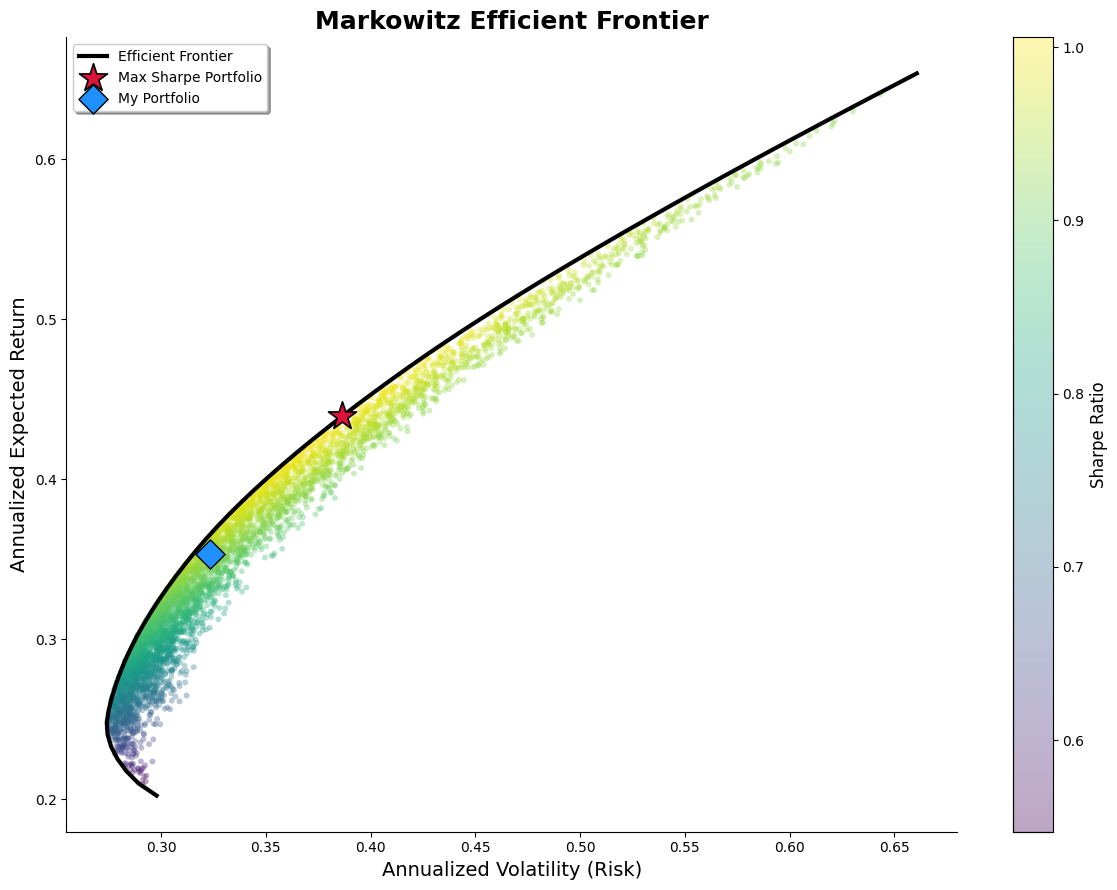

In [17]:
import seaborn as sns

# -----------------------------
# 6) Aesthetic Plot (Seaborn)
# -----------------------------

plt.figure(figsize=(12,9))

# color palette
cmap = plt.cm.viridis

# Random portfolios cloud
sc = plt.scatter(vols, rets,
                 c=sharpes,
                 cmap=cmap,
                 alpha=0.35,
                 s=18,
                 edgecolor='none')

cbar = plt.colorbar(sc)
cbar.set_label("Sharpe Ratio", fontsize=12)

# Efficient frontier curve
plt.plot(frontier_vols,
         target_returns,
         color="black",
         linewidth=3,
         label="Efficient Frontier")

# Max Sharpe portfolio
plt.scatter(opt_vol, opt_ret,
            color="crimson",
            marker="*",
            s=450,
            edgecolor="black",
            linewidth=1.2,
            label="Max Sharpe Portfolio",
            zorder=5)

# Your portfolio
plt.scatter(my_vol, my_ret,
            color="dodgerblue",
            marker="D",
            s=220,
            edgecolor="black",
            linewidth=1,
            label="My Portfolio",
            zorder=6)

# Labels
plt.xlabel("Annualized Volatility (Risk)", fontsize=14)
plt.ylabel("Annualized Expected Return", fontsize=14)
plt.title("Markowitz Efficient Frontier", fontsize=18, weight="bold")

# Legend styling
plt.legend(frameon=True, fancybox=True, shadow=True)

sns.despine()
plt.tight_layout()
plt.show()


In [ ]:
"The efficient frontier is the set of portfolios that provide the highest expected return for each level of risk. The optimal (tangency) portfolio is the point on this frontier that maximizes the Sharpe ratio."

In [19]:
!pip install plotly


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
!pip install nbformat


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scr.logger import setup_logger

logger = setup_logger()

RETURNS_PATH = "data/processed/returns.parquet"

from dataclasses import dataclass

@dataclass
class PortfolioResults:
    name:str
    weights: pd.Series
    metrics: dataclass
    var: float
    cvar: float

@dataclass
class PortfolioMetrics:
    annual_return: float
    annual_volatility: float
    sharpe_ratio: float
    max_drawdown: float

def load_returns() -> pd.DataFrame:
    try:
        returns = pd.read_parquet(RETURNS_PATH)
        logger.info("Returns loaded for portfolio engine")
        return returns
    except FileNotFoundError:
        logger.exception("Returns file missing")
        raise
    except Exception as e:
        logger.exception(f"The file did not load | Reason : {e}")
        raise


def estimate_statistics(returns:pd.DataFrame) -> tuple[pd.Series,pd.DataFrame]:
    """
    Estimate annualized expected return of each stock and covariance between them
    """
    mu = returns.mean() * 252
    cov = returns.cov() * 252
    return mu, cov


def portfolio_performance(weights:list[float], 
                          mu:pd.Series, 
                          cov:pd.DataFrame,
                          rf:float =0) -> tuple[float,float,float]:
    """
    Returns (return, volatility, sharpe) based on weights
    """
    ret = np.dot(weights, mu)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    sharpe = (ret - rf) / vol
    return ret, vol, sharpe


def optimize_portfolio(mu:pd.Series, 
                       cov:pd.DataFrame) -> np.ndarray[float]:
    """
    For a porfilio with given annualized mean returns and covaraince, this
    function find the optimal weights which increases returns and decreases risk,
    by maximizing the sharpe ratio
    
    Parameters:
        mu: The annualized mean returns of the portolio based on historical returns data
        sigma: The annualized risk associated with the given portfolio 
            calculated using covariance matrix of stocks in the portfolio
        
    Returns:
        array of optimized weights
    """
    n = len(mu)

    def neg_sharpe(weights):
        _, _, sharpe = portfolio_performance(weights, mu, cov)
        return -sharpe

    constraints = ({
        'type': 'eq',
        'fun': lambda w: np.sum(w) - 1
    })

    bounds = tuple((0.05,1) for _ in range(n))
    init_guess = np.ones(n) / n

    result = minimize(
        neg_sharpe,
        init_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    if not result.success:
        raise RuntimeError(f"Optimization failed: {result.message}")
    weights = result.x

    if np.any(np.isnan(weights)):
        raise RuntimeError("Optimizer produced NaN weights")

    if not np.isclose(weights.sum(), 1.0, atol=1e-2):
        raise RuntimeError("Optimizer returned invalid weights (do not sum to 1)")
    
    logger.info("Portfolio optimization complete")
    return result.x


def portfolio_metrics(weights:np.ndarray[float], 
                      returns:pd.DataFrame) -> dict[str:float]:
    """
    Backtesting done on the returns data we had using the portfolio
    weights we obtained and obtaining key metrics

    Parameter:
        weights: the optimized weights of our portfolio
        returns: percentage returns dataset of our stocks

    Returns:
        A metrics dictionary with
            - Annual Return: the annualized returns of the portfolio with our weights
            - Annual Volatility: the annualized returns of the portfolio with our weights
            - Sharpe Ratio: Annual Return / Annual Volatility, Higher the better
            - Max Drawdown: The lowest our portfolio drops from its peak returns value
    """

    port_returns = returns @ weights

    ann_return = port_returns.mean() * 252
    ann_vol = port_returns.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol
    if ann_vol < 1e-8:
        raise RuntimeError("Portfolio volatility too small — likely degenerate weights")

    # If I started with ₹1, how much money would I end up with?
    cumulative = (1 + port_returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    max_dd = drawdown.min()

    
    return PortfolioMetrics(annual_return=ann_return,
                            annual_volatility=ann_vol,
                            sharpe_ratio=sharpe,
                            max_drawdown=max_dd)


def monte_carlo_simulation(weights:np.ndarray[float], 
                           mu:pd.Series, 
                           cov:pd.DataFrame, 
                           days:int = 252, 
                           sims:float = 3000) -> np.ndarray:
    """
    This function simulates different returns trajectories our
    portfolio could have and gives back the cummulative returns for each path

    Parameters:
        weights: the optimized weights of our portfolio
        mu: the mean annualized returns of each stock
        cov: the covavriance matrix of each stocks in our portfolio
        days: the number of days we want to simulate
        sims: the number of simulations we want to run

    Returns:
        results : array containing the cumulative returns per year for each path dim(sims,)
    """
    port_mu = np.dot(weights, mu)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))

    results = []

    for _ in range(sims):
        simulated_returns = np.random.normal(
            port_mu/252,
            port_vol/np.sqrt(252),
            days
        )
        path = (1 + simulated_returns).cumprod()
        results.append(path[-1])

    results = np.array(results)
    if not np.all(np.isfinite(results)):
        raise RuntimeError("Monte Carlo simulation produced invalid values")
    return results

def compute_var_cvar(simulated_values:list[float], 
                     confidence:float=0.95) -> tuple[float,float]:
    """
    Calculates the Value at risk and the Conditional Value at risk
    for a given list of simulated portfolio returns

    Parameters:
        simulated_values: list containg simulated returns from Monte carlo simulation
        confidence: The probability of being sure threshold (useally 0.95 or 95%)

    Returns:
        var: The value of return(r) at which we could be 95% sure our portfolio 
            will not loose more than (1-r)% of the money invested in a year
        cvar: The average value our portfolio can loose if we if one of those rare bad years occurs
    """
    percentile = 100 * (1 - confidence)
    var = np.percentile(simulated_values, percentile)
    cvar = simulated_values[simulated_values <= var].mean()
    return var, cvar

def validate_cov(cov):
    eigvals = np.linalg.eigvalsh(cov)
    if np.any(eigvals < -1e-8):
        raise ValueError("Covariance matrix is not positive semi-definite")

def validate_weights(weights: np.ndarray) -> None:
    if not isinstance(weights, np.ndarray):
        raise TypeError("weights must be numpy array")

    if weights.ndim != 1:
        raise ValueError("weights must be 1D")

    if not np.isclose(weights.sum(), 1.0, atol=1e-2):
        raise ValueError("weights must sum to 1")

    if np.any(np.isnan(weights)):
        raise ValueError("weights contain NaN")


def evaluate_portfolio(weights:np.ndarray, returns:pd.DataFrame, name:str) -> PortfolioResults:
    """
    Evalutes the portfolio for given weights and stores it as a dataclass
    """
    validate_weights(weights)
    if returns.shape[0] <= returns.shape[1]:
        raise ValueError(
            f"Not enough observations to estimate covariance reliably "
            f"(T={returns.shape[0]}, N={returns.shape[1]})"
        )

    if returns.shape[1] != len(weights):
        raise ValueError("weights do not match number of assets")
    
    mu, cov = estimate_statistics(returns)
    validate_cov(cov)
    metrics = portfolio_metrics(weights, returns)
    simulated_returns = monte_carlo_simulation(weights, mu, cov)
    var, cvar = compute_var_cvar(simulated_returns)

    return PortfolioResults(name=name, weights=weights, metrics=metrics, var=var, cvar=cvar)



def optimized_portfolio_construction(tickers) -> PortfolioResults | None:
    logger.info("Starting Portfolio Construction")

    try:
        returns = load_returns()
        returns = returns[tickers]
        logger.info("Loaded the returns dataframe")
        mu, cov = estimate_statistics(returns)
        validate_cov(cov)
        opt_weights = optimize_portfolio(mu,cov)
        results = evaluate_portfolio(opt_weights,returns,name="Optimal")

        logger.info("Portfolio optimization completed")
        return results
    except Exception:
        logger.exception(f"Portfolio Optimization failed")
        raise


def general_portfolio_construction(tickers:list[str],weights:np.ndarray,name:str) -> PortfolioResults | None:
    
    logger.info("Starting Portfolio Construction for given weights")

    try:
        returns = load_returns()
        returns = returns[tickers]
        results = evaluate_portfolio(weights,returns,name)
        logger.info("Portfolio Construction completed")
        return results
    except Exception:
        logger.exception(f"Portfolio Construction failed")
        raise


In [ ]:

# ================================
# QUANT PORTFOLIO SYSTEM
# ================================

import numpy as np
import pandas as pd
from dataclasses import dataclass
from scipy.optimize import minimize

# -------------------------------------------------
# CONFIG
# -------------------------------------------------
RETURNS_PATH = "data/processed/returns.parquet"


# =================================================
# DATA STRUCTURES
# =================================================

@dataclass
class PortfolioMetrics:
    annual_return: float
    annual_volatility: float
    sharpe_ratio: float
    max_drawdown: float


# =================================================
# VALIDATIONS
# =================================================

def validate_cov(cov: pd.DataFrame):
    eigvals = np.linalg.eigvalsh(cov)
    if np.any(eigvals < -1e-8):
        raise ValueError("Covariance matrix is not positive semi-definite")


def validate_weights(weights: np.ndarray):
    if not isinstance(weights, np.ndarray):
        raise TypeError("weights must be numpy array")

    if weights.ndim != 1:
        raise ValueError("weights must be 1D")

    if np.any(np.isnan(weights)):
        raise ValueError("weights contain NaN")

    if not np.isclose(weights.sum(), 1.0, atol=1e-2):
        raise ValueError("weights must sum to 1")


# =================================================
# MARKET DATA
# =================================================

class MarketData:
    """
    Represents market statistical model (mu, Sigma, returns)
    """

    def __init__(self, tickers: list[str]):
        self.tickers = tickers
        self.returns = self._load_returns()
        self.mu, self.cov = self._estimate_statistics()
        validate_cov(self.cov)

    def _load_returns(self) -> pd.DataFrame:
        returns = pd.read_parquet(RETURNS_PATH)
        returns = returns[self.tickers]
        if returns.shape[0] <= returns.shape[1]:
            raise ValueError(
                f"Not enough observations (T={returns.shape[0]}, N={returns.shape[1]})"
            )
        return returns

    def _estimate_statistics(self):
        mu = self.returns.mean() * 252
        cov = self.returns.cov() * 252
        return mu, cov


# =================================================
# PORTFOLIO OBJECT (CORE ENTITY)
# =================================================

class Portfolio:
    """
    Persistent financial object representing a tradable portfolio
    """

    def __init__(self, market_data: MarketData, weights: np.ndarray, name="Portfolio"):
        validate_weights(weights)

        if len(weights) != len(market_data.tickers):
            raise ValueError("weights do not match number of assets")

        self.data = market_data
        self.weights = np.array(weights)
        self.name = name
        self.metrics = self.metrics()
		
    # ----------------------------
    # BASIC PROPERTIES
    # ----------------------------

    @property
    def expected_return(self):
        return float(np.dot(self.weights, self.data.mu))

    @property
    def volatility(self):
        return float(np.sqrt(self.weights.T @ self.data.cov @ self.weights))

    @property
    def sharpe(self, rf=0.0):
        return (self.expected_return - rf) / self.volatility

    # ----------------------------
    # PERFORMANCE METRICS
    # ----------------------------

    def metrics(self) -> PortfolioMetrics:
        port_returns = self.data.returns @ self.weights

        ann_return = port_returns.mean() * 252
        ann_vol = port_returns.std() * np.sqrt(252)
        sharpe = ann_return / ann_vol

        cumulative = (1 + port_returns).cumprod()
        peak = cumulative.cummax()
        drawdown = (cumulative - peak) / peak
        max_dd = drawdown.min()

        return PortfolioMetrics(
            annual_return=float(ann_return),
            annual_volatility=float(ann_vol),
            sharpe_ratio=float(sharpe),
            max_drawdown=float(max_dd),
        )

    # ----------------------------
    # RISK SIMULATION
    # ----------------------------

    def simulate_paths(self, days=252, sims=3000):
        port_mu = np.dot(self.weights, self.data.mu)
        port_vol = np.sqrt(self.weights.T @ self.data.cov @ self.weights)

        results = []

        for _ in range(sims):
            simulated_returns = np.random.normal(
                port_mu / 252,
                port_vol / np.sqrt(252),
                days,
            )
            path = (1 + simulated_returns).cumprod()
            results.append(path[-1])

        results = np.array(results)

        if not np.all(np.isfinite(results)):
            raise RuntimeError("Monte Carlo produced invalid values")

        return results

    def var_cvar(self, confidence=0.95):
        sims = self.simulate_paths()
        percentile = 100 * (1 - confidence)
        var = np.percentile(sims, percentile)
        cvar = sims[sims <= var].mean()
        return float(var), float(cvar)


# =================================================
# OPTIMIZER
# =================================================

class MeanVarianceOptimizer:
    """
    Produces portfolios — does not store one.
    """

    def __init__(self, market_data: MarketData):
        self.data = market_data

    def _portfolio_performance(self, weights):
        ret = np.dot(weights, self.data.mu)
        vol = np.sqrt(weights.T @ self.data.cov @ weights)
        sharpe = ret / vol
        return ret, vol, sharpe

    def max_sharpe(self):
        n = len(self.data.tickers)

        def neg_sharpe(weights):
            return -self._portfolio_performance(weights)[2]

        constraints = ({
            'type': 'eq',
            'fun': lambda w: np.sum(w) - 1
        })

        bounds = tuple((0.05, 1) for _ in range(n))
        init_guess = np.ones(n) / n

        result = minimize(
            neg_sharpe,
            init_guess,
            method="SLSQP",
            bounds=bounds,
            constraints=constraints,
        )

        if not result.success:
            raise RuntimeError(f"Optimization failed: {result.message}")

        return Portfolio(self.data, result.x, name="MaxSharpe")


# =================================================
# EXAMPLE USAGE
# =================================================
if __name__ == "__main__":

    tickers = ["RELIANCE", "TCS", "HDFCBANK", "INFY", "ICICIBANK"]

    # Load market
    market = MarketData(tickers)

    # Optimized portfolio
    optimizer = MeanVarianceOptimizer(market)
    opt_port = optimizer.max_sharpe()

    # Equal weight portfolio
    eq_weights = np.ones(len(tickers)) / len(tickers)
    eq_port = Portfolio(market, eq_weights, name="EqualWeight")

    # Metrics
    print("Optimal:", opt_port.metrics())
    print("Equal:", eq_port.metrics())

    # Risk
    print("Optimal VaR/CVaR:", opt_port.var_cvar())
    print("Equal VaR/CVaR:", eq_port.var_cvar())



KeyError: "None of [Index(['RELIANCE', 'TCS', 'HDFCBANK', 'INFY', 'ICICIBANK'], dtype='object')] are in the [columns]"

In [12]:
# from scr.portfolio_making import load_returns
# import numpy as np
# import pandas as pd
# from scipy.optimize import minimize
# from scr.logger import setup_logger

# RISK_FREE_RATE = 0.05

# logger = setup_logger()

# def validate_cov(cov: pd.DataFrame):
#     eigvals = np.linalg.eigvalsh(cov)
#     if np.any(eigvals < -1e-8):
#         raise ValueError("Covariance matrix is not positive semi-definite")

# def validate_weights(weights: np.ndarray):
#     if not isinstance(weights, np.ndarray):
#         raise TypeError("weights must be numpy array")
#     if weights.ndim != 1:
#         raise ValueError("weights must be 1D")
#     if np.any(np.isnan(weights)):
#         raise ValueError("weights contain NaN")
#     if not np.isclose(weights.sum(), 1.0, atol=1e-2):
#         raise ValueError("weights must sum to 1")


# # Market Data
# class MarketData:
# 	"""
# 	Represents market statistical model (mu, Sigma, returns)
# 	"""
# 	def __init__(self, tickers: list[str]):
# 		self.tickers = tickers
# 		self.returns = self._load_returns()
# 		self.mu, self.cov = self._estimate_statistics()
# 		validate_cov(self.cov)

# 	def _load_returns(self) -> pd.DataFrame:
# 		returns = load_returns()
# 		returns = returns[self.tickers]
# 		return returns

# 	def _estimate_statistics(self):
# 		mu = self.returns.mean() * 252
# 		cov = self.returns.cov() * 252
# 		return mu, cov


# # PORTFOLIO OBJECT 
# class Portfolio:
# 	"""
# 	Persistent financial object representing a tradable portfolio
# 	"""
# 	def __init__(self, market_data: MarketData, weights: np.ndarray, name="Portfolio"):
# 		validate_weights(weights)
# 		if len(weights) != len(market_data.tickers):
# 			raise ValueError("weights do not match number of assets")
# 		self.data = market_data
# 		self.weights = np.array(weights)
# 		self.name = name

# 	@property
# 	def expected_return(self):
# 		return float(np.dot(self.weights, self.data.mu))
# 	@property
# 	def volatility(self):
# 		return float(np.sqrt(self.weights.T @ self.data.cov @ self.weights))
# 	@property
# 	def sharpe(self, rf=RISK_FREE_RATE):
# 		return (self.expected_return - rf) / self.volatility
# 	@property
# 	def max_drawdown(self):
# 		port_returns = self.data @ self.weights
# 		cumulative = (1 + port_returns).cumprod()
# 		peak = cumulative.cummax()
# 		drawdown = (cumulative - peak) / peak
# 		max_dd = drawdown.min()
# 		return max_dd
	
# 	def simulate_paths(self, days=252, sims=3000):
# 		port_mu = np.dot(self.weights, self.data.mu)
# 		port_vol = np.sqrt(self.weights.T @ self.data.cov @ self.weights)
# 		results = []
# 		for _ in range(sims):
# 			simulated_returns = np.random.normal(
# 				port_mu / 252,
# 				port_vol / np.sqrt(252),
# 				days,
# 			)
# 			path = (1 + simulated_returns).cumprod()
# 			results.append(path[-1])
# 		results = np.array(results)
# 		if not np.all(np.isfinite(results)):
# 			raise RuntimeError("Monte Carlo produced invalid values")
# 		return results
	
# 	@property
# 	def var_cvar(self, confidence=0.95):
# 		sims = self.simulate_paths()
# 		percentile = 100 * (1 - confidence)
# 		var = np.percentile(sims, percentile)
# 		cvar = sims[sims <= var].mean()
# 		return float(var), float(cvar)


# # OPTIMIZER
# class MeanVarianceOptimizer:
# 	"""
# 	Produces portfolios — does not store one.
# 	"""
# 	def __init__(self, market_data: MarketData):
# 		self.data = market_data

# 	def _portfolio_performance(self, weights):
# 		ret = np.dot(weights, self.data.mu)
# 		vol = np.sqrt(weights.T @ self.data.cov @ weights)
# 		sharpe = (ret - RISK_FREE_RATE)/ vol
# 		return ret, vol, sharpe
	
# 	def max_sharpe(self):
# 		n = len(self.data.tickers)
# 		def neg_sharpe(weights):
# 			return -self._portfolio_performance(weights)[2]
# 		constraints = ({
# 		    'type': 'eq',
# 		    'fun': lambda w: np.sum(w) - 1
# 		})
# 		bounds = tuple((0, 1) for _ in range(n))
# 		init_guess = np.ones(n) / n
# 		result = minimize(
# 		    neg_sharpe,
# 		    init_guess,
# 		    method="SLSQP",
# 		    bounds=bounds,
# 		    constraints=constraints,
# 		)
# 		if not result.success:
# 			raise RuntimeError(f"Optimization failed: {result.message}")
# 		return Portfolio(self.data, result.x, name="MaxSharpe")

# class PortfoliosForTickers:
# 	"""
# 	Represents a trading universe for a specific set of tickers.
# 	Stores multiple portfolios built on the same market data.
# 	"""
# 	def __init__(self, tickers: list[str]):
# 		self.tickers = tuple(tickers)
# 		self.market = MarketData(tickers)
# 		self.portfolios: dict[str, Portfolio] = {}
		
# 		# automatically create optimized portfolio
# 		optimizer = MeanVarianceOptimizer(self.market)
# 		optimal = optimizer.max_sharpe()
# 		self.portfolios["Optimal"] = optimal

# 	def add_portfolio(self, weights: np.ndarray, name: str):
# 		port = Portfolio(self.market, weights, name)
# 		self.portfolios[name] = port

# 	def get(self, name: str) -> Portfolio:
# 		return self.portfolios[name]

# 	def all_portfolios(self,just_names=True):
# 		if just_names:
# 			return list(self.portfolios.keys()) 
# 		else:
# 			return list(self.portfolios.values())


In [1]:

from scr.portfolio_making import *
from scr.efficient_frontier import plot_efficient_frontier,compute_frontier_data

tickers = ['MSFT','AAPL','GOOG','TSLA']

portfolio_universe = PortfoliosForTickers(tickers)
# cov, mu = portfolio_universe.market.cov,portfolio_universe.market.mu
# frontier = compute_frontier_data(mu,cov)
# plot_efficient_frontier(portfolio_universe.all_portfolios(False),frontier)

In [3]:
portfolio_universe.all_portfolios()

['Equal Weight Portfolio',
 'Max Sharpe Portfolio',
 'Minimum Variance Portfolio',
 'Risk Parity Portfolio',
 'Momentum Portfolio']

In [2]:
portfolio_universe.compare_metric("sharpe")

{'Equal Weight Portfolio': 0.9394489484787901,
 'Max Sharpe Portfolio': 1.007839816297799,
 'Minimum Variance Portfolio': 0.7171495019679972,
 'Risk Parity Portfolio': 0.8882954027204251,
 'Momentum Portfolio': 1.0022348734219613}

In [3]:
portfolio_universe.compare_metric("volatility")

{'Equal Weight Portfolio': 0.32327575700044664,
 'Max Sharpe Portfolio': 0.38638346552761393,
 'Minimum Variance Portfolio': 0.2740862139838919,
 'Risk Parity Portfolio': 0.29680057133228693,
 'Momentum Portfolio': 0.3548530889005773}

In [6]:
portfolio_universe.compare_metric("expected_return")

{'Equal Weight Portfolio': 0.35370106998275447,
 'Max Sharpe Portfolio': 0.43941264091785737,
 'Minimum Variance Portfolio': 0.24656079185484198,
 'Risk Parity Portfolio': 0.31364658303926607,
 'Momentum Portfolio': 0.4056461406376621}

In [2]:
portfolios = portfolio_universe.all_portfolios(just_names=False)

In [1]:
import plotly.graph_objects as go


from scr.portfolio_making import *

tickers = ['MSFT','AAPL','GOOG','TSLA']

portfolio_universe = PortfoliosForTickers(tickers)

def render_weights_bar(portfolios):
	fig = go.Figure()

	fig.add_trace(go.Bar(
				x=[strategy for strategy,p in portfolios],
				y=[p.weights for _,p in portfolios],  # i = index of ticker
				name="ba",
			))

	fig.update_layout(
		barmode="stack",
		yaxis=dict(range=[0, 1], tickformat=".0%"),
		xaxis_title="Portfolio",
		yaxis_title="Weight",
	)
	fig.show("browser")

portfolios = portfolio_universe.all_portfolios(just_names=False)

# render_weights_bar(portfolios)
portfolios

[('Equal Weight Portfolio', <scr.portfolio_making.Portfolio at 0x18ac6204aa0>),
 ('Max Sharpe Portfolio', <scr.portfolio_making.Portfolio at 0x18ac61ce9c0>),
 ('Minimum Variance Portfolio',
  <scr.portfolio_making.Portfolio at 0x18ac60b3d10>),
 ('Risk Parity Portfolio', <scr.portfolio_making.Portfolio at 0x18ac606b1a0>),
 ('Momentum Portfolio', <scr.portfolio_making.Portfolio at 0x18ac6279a30>)]

In [ ]:
import pandas as pd
import plotly.graph_objects as go

tickers = ['MSFT','AAPL','GOOG','TSLA']

def portfolio_weights_dataframe(portfolios):
    df = pd.DataFrame(index=tickers)
    for name,port in portfolios:
        df[name] = port.weights
    return df


def plot_portfolio_weights(portfolios):
    df = portfolio_weights_dataframe(portfolios)
    df = df.T

    fig = go.Figure()
    for portfolio_name in df.columns:
        fig.add_trace(
            go.Bar(
                x=df.index,
                y=df[portfolio_name],
                name=portfolio_name
            )
        )

    fig.update_layout(
        barmode="stack",
        title="Portfolio Allocation Comparison",
        xaxis_title="Stocks",
        yaxis_title="Portfolio Weight",
        yaxis=dict(tickformat=".0%"),
    )
    fig.show("browser")
    

plot_portfolio_weights(portfolios)

In [20]:
import pandas as pd

def portfolio_metrics_dataframe(portfolios):

    rows = []

    for name,port in portfolios:

        var, cvar = port.var_cvar

        rows.append({
            "Strategy": name,
            "Expected Return": port.expected_return,
            "Volatility": port.volatility,
            "Sharpe Ratio": port.sharpe,
            "Max Drawdown": port.max_drawdown,
            "VaR (95%)": var,
            "CVaR (95%)": cvar
        })

    df = pd.DataFrame(rows).set_index("Strategy")
    return df

df = portfolio_metrics_dataframe(portfolios)
df

,Expected Return,Volatility,Sharpe Ratio,Max Drawdown,VaR (95%),CVaR (95%)
Strategy,,,,,,
Equal Weight Portfolio,0.353701,0.323276,0.939449,-0.456279,0.805768,0.699310
Max Sharpe Portfolio,0.434641,0.383818,1.002143,-0.540957,0.748975,0.641483
Minimum Variance Portfolio,0.266373,0.278633,0.776551,-0.368044,0.779562,0.691923
Risk Parity Portfolio,0.313647,0.296801,0.888295,-0.412640,0.815151,0.713981
Momentum Portfolio,0.405646,0.354853,1.002235,-0.504028,0.778316,0.678636


In [ ]:
def plot_strategy_metrics(df):

    fig = go.Figure()
    # df = df.T

    for metric in df.columns:
        fig.add_trace(
            go.Bar(
                x=df.index,
                y=df[metric],
                name=metric
            )
        )

    fig.update_layout(
        barmode="group",
        title="Portfolio Strategy Metrics Comparison",
        yaxis_title="Metric Value"
    )

    fig.show("browser")
    
plot_strategy_metrics(df)

In [ ]:
def portfolio_monthly_returns(port):

    daily_returns = port.data.returns @ port.weights
    monthly = (1 + daily_returns).resample("ME").prod() - 1  #Understnad the formula here, diff because start point chenages
    return monthly

import plotly.graph_objects as go

def plot_monthly_heatmap(port):

    monthly = portfolio_monthly_returns(port)

    df = monthly.to_frame("ret")
    df["Year"] = df.index.year
    df["Month"] = df.index.month

    pivot = df.pivot(index="Year", columns="Month", values="ret")

    fig = go.Figure(go.Heatmap(
        z=pivot.values,
        x=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
        y=pivot.index,
        colorscale="RdYlGn",
        zmid=0
    ))

    fig.update_layout(
        title=f"Monthly Returns Heatmap — {port.name}",
        xaxis_title="Month",
        yaxis_title="Year"
    )

    fig.show("browser")
    
port = portfolio_universe.get("Max Sharpe Portfolio")
plot_monthly_heatmap(port)

In [40]:
import numpy as np
import plotly.graph_objects as go

def plot_rolling_sharpe(portfolios, window=126, rf=0.05):
    """
    Plot rolling Sharpe ratios for multiple Portfolio objects
    """

    fig = go.Figure()

    for name,port in portfolios:

        # portfolio daily returns
        r = port.data.returns @ port.weights

        # convert annual risk-free rate to daily
        rf_daily = rf / 252

        # excess returns
        excess = r - rf_daily

        # rolling annualized Sharpe
        roll_mean = excess.rolling(window).mean() * 252
        roll_vol = excess.rolling(window).std() * np.sqrt(252)
        rolling_sharpe = roll_mean / roll_vol

        # add line to SAME figure
        fig.add_trace(
            go.Scatter(
                x=rolling_sharpe.index,
                y=rolling_sharpe,
                name=port.name,
                line=dict(width=2)
            )
        )
        fig.add_hline(y=0, line_dash="dash", line_color="black")
    fig.update_layout(
        title="Rolling Sharpe Ratio Comparison",
        yaxis_title="Sharpe Ratio",
        xaxis_title="Date",
        legend_title="Portfolio Strategy"
    )

    fig.show("browser")
    

port = portfolio_universe.get("Max Sharpe Portfolio")  
portfolios = portfolio_universe.all_portfolios(just_names=False)
plot_rolling_sharpe(portfolios)

In [42]:
import numpy as np

def portfolio_daily_returns(port):
    """Compute daily portfolio return series"""
    return port.data.returns @ port.weights

def plot_underwater(portfolios):

    fig = go.Figure()

    for name,port in portfolios:
        r = portfolio_daily_returns(port)

        wealth = (1 + r).cumprod()
        peak = wealth.cummax()
        drawdown = (wealth - peak) / peak

        fig.add_trace(go.Scatter(
            x=drawdown.index,
            y=drawdown,
            fill="tozeroy",
            name=port.name
        ))

    fig.update_layout(
        title="Underwater Plot (Drawdown Comparison)",
        yaxis_title="Drawdown",
        xaxis_title="Date"
    )
    fig.show("browser")
    
plot_underwater(portfolios)

In [43]:
def plot_terminal_wealth_distribution(portfolios, sims=4000):

    fig = go.Figure()

    for name,port in portfolios:
        results = port.simulate_paths(sims=sims)

        fig.add_trace(go.Histogram(
            x=results,
            opacity=0.5,
            name=port.name
        ))

    fig.update_layout(
        barmode="overlay",
        title="Monte Carlo Terminal Wealth Distribution",
        xaxis_title="Final Wealth (Starting = 1)",
        yaxis_title="Frequency"
    )

    fig.show("browser")
    
plot_terminal_wealth_distribution(portfolios)

In [46]:
import pandas as pd

def compute_turnover(port):

    returns = port.data.returns

    monthly_prices = (1 + returns).cumprod().resample("ME").last()
    monthly_returns = monthly_prices.pct_change().dropna()

    weights = np.array(port.weights)
    prev_w = weights.copy()

    turnovers = []

    for _, row in monthly_returns.iterrows():

        new_w = prev_w * (1 + row.values)
        new_w = new_w / new_w.sum()

        turnover = np.sum(np.abs(new_w - prev_w))
        turnovers.append(turnover)

        # rebalance back to target weights
        prev_w = weights.copy()

    return pd.Series(turnovers, index=monthly_returns.index)


def plot_turnover(portfolios):

    fig = go.Figure()

    for _,port in portfolios:
        turnover = compute_turnover(port)
        print(turnover)

        fig.add_trace(go.Bar(
            x=turnover.index,
            y=turnover,
            name=port.name
        ))

    fig.update_layout(
        title="Portfolio Turnover (Rebalancing Activity)",
        yaxis_title="Turnover",
        xaxis_title="Date"
    )

    fig.show("browser")

plot_turnover(portfolios)

Date
2020-02-29    0.042618
2020-03-31    0.070593
2020-04-30    0.103656
2020-05-31    0.016089
2020-06-30    0.075043
                ...   
2025-10-31    0.045367
2025-11-30    0.067476
2025-12-31    0.024793
2026-01-31    0.056078
2026-02-28    0.039994
Freq: ME, Length: 73, dtype: float64
Date
2020-02-29    0.047335
2020-03-31    0.055924
2020-04-30    0.124713
2020-05-31    0.006274
2020-06-30    0.121853
                ...   
2025-10-31    0.059393
2025-11-30    0.088093
2025-12-31    0.031048
2026-01-31    0.063452
2026-02-28    0.035698
Freq: ME, Length: 73, dtype: float64
Date
2020-02-29    0.028303
2020-03-31    0.047370
2020-04-30    0.028016
2020-05-31    0.021457
2020-06-30    0.052514
                ...   
2025-10-31    0.049773
2025-11-30    0.064410
2025-12-31    0.006317
2026-01-31    0.065208
2026-02-28    0.043244
Freq: ME, Length: 73, dtype: float64
Date
2020-02-29    0.036394
2020-03-31    0.061676
2020-04-30    0.073043
2020-05-31    0.017916
2020-06-30    0.06

In [26]:
ans = portfolio_monthly_returns(port)
ans

Date
2020-01-31    0.151131
2020-02-29   -0.041882
2020-03-31   -0.103190
2020-04-30    0.234254
2020-05-31    0.061146
                ...   
2025-10-31    0.062205
2025-11-30    0.015033
2025-12-31   -0.002584
2026-01-31   -0.029747
2026-02-28   -0.048390
Freq: ME, Length: 74, dtype: float64

In [8]:
for name,p in portfolios:
    print(name)
    print(p.weights)

Equal Weight Portfolio
[0.25 0.25 0.25 0.25]
Max Sharpe Portfolio
[0.05       0.05       0.49536788 0.40463212]
Minimum Variance Portfolio
[0.41009378 0.27351295 0.26639328 0.05      ]
Risk Parity Portfolio
[0.29120014 0.27691551 0.28055575 0.1513286 ]
Momentum Portfolio
[0.         0.17775417 0.49965392 0.32259191]


In [7]:

portfolios = portfolio_universe.all_portfolios(just_names=False)

fig = go.Figure()
for i, ticker in enumerate(tickers):
    fig.add_trace(go.Bar(
        x=[p.name for p in portfolios],
        y=[p.weights[i] for p in portfolios],
        name=ticker,
    ))

fig.update_layout(barmode="stack")

NameError: name 'go' is not defined

In [13]:
portfolios

In [3]:
portfolio_universe.all_portfolios()

['Optimal portfolio', 'Equal Weighted Portfolio']

In [3]:
eq = portfolio_universe.get('Equal Weighted Portfolio')
eq.weights

array([0.25, 0.25, 0.25, 0.25])